With this Notebook, the datasets which were created by CLEO of all clusters using rain mask with 5 timestep holes removed will be compared.


In [26]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import yaml
from typing import Tuple

from sdm_eurec4a.visulization import set_custom_rcParams, adjust_lightness_array, gen_color

from sdm_eurec4a.identifications import (
    match_clouds_and_cloudcomposite,
    match_clouds_and_dropsondes,
    select_individual_cloud_by_id,
)

from sdm_eurec4a import RepositoryPath
from sdm_eurec4a.reductions import shape_dim_as_dataarray
from sdm_eurec4a.conversions import msd_from_psd

In [27]:
def adjust_spines(ax, visible_spines, position=("outward", 5)):
    ax.label_outer(remove_inner_ticks=False)

    for loc, spine in ax.spines.items():
        if loc in visible_spines:
            spine.set_position(position)  # outward by 10 points
        else:
            spine.set_visible(False)
plt.fill_between
def plot_cloud_extent(ax, cluster, color = "k", alpha=0.5):
    x_min, x_max = ax.get_xlim()
    y1 = cluster.alt.values[0] + 100
    y2 = cluster.alt.values[0] - 100
    ax.fill_between(
        x = [x_min, x_max],
        y1 = [y1, y1],
        y2 = [y2, y2],
        color = color,
        alpha=alpha,
        linestyle = '',
    )

In [28]:

def plot_multiple_timesteps_same_ax(
        ax : plt.axes, 
        x : xr.DataArray, 
        y : xr.DataArray,
        timesteps : np.ndarray,
        time_name : str = "time", 
        cmap : str = "cividis_r",
        label_func = lambda t: f"{t/60:.0f} min",
        **kwargs : dict,
        ):
            # Plot the cummulative evaporation over time

    n = len(timesteps)
    colors = gen_color(n = n, cmap = "cividis_r")

    cmap = mpl.colors.LinearSegmentedColormap.from_list("temporary_cmap", colors, N=n)

    if time_name not in y.dims :
        y = y.expand_dims(time = len(timesteps))
        y["time"] = timesteps

    for i, t in enumerate(timesteps):
        t_value = ds_euler["time"].sel(time = t, method = 'nearest')
        result = ax.plot(
            x.sel({time_name : t_value}),
            y.sel({time_name : t_value}),
            c = cmap(i),
            label = label_func(t_value),
            **kwargs,
        )
    return result
def plot_multiple_timesteps_diff_ax(
        axs : Tuple[plt.axes], 
        x : xr.DataArray, 
        y : xr.DataArray,
        timesteps : np.ndarray,
        time_name : str = "time", 
        cmap : str = "cividis_r",
        label_func = lambda t: f"{t/60:.0f} min",
        **kwargs : dict,
        ):
            # Plot the cummulative evaporation over time

    n = len(timesteps)
    assert np.size(axs) >= n, "Number of axes must be equal to number of timesteps"

    colors = gen_color(n = n, cmap = "cividis_r")

    cmap = mpl.colors.LinearSegmentedColormap.from_list("temporary_cmap", colors, N=n)


    if time_name not in y.dims :
        y = y.expand_dims(time = len(timesteps))
        y["time"] = timesteps

    result = list()
    for i, t in enumerate(timesteps):
        ax = axs.flatten()[i]
        t_value = ds_euler["time"].sel(time = t, method = 'nearest')
        result.append(
            ax.plot(
                x.sel({time_name : t_value}),
                y.sel({time_name : t_value}),
                c = cmap(i),
                label = label_func(t_value),
                **kwargs,
            )
        )
        ax.set_title(label_func(t_value))
    return result


In [29]:
plt.style.use("default")
default_colors = set_custom_rcParams()
darker_colors = adjust_lightness_array(default_colors, 0.75)

REPOSITORY_ROOT = RepositoryPath("levante").get_repo_dir()

In [30]:
config_yaml_filepath = REPOSITORY_ROOT / Path("data/model/input/new/clusters_301.yaml")

with open(config_yaml_filepath, "r") as file:
    config_yaml = yaml.safe_load(file)

identification_type = config_yaml["cloud"]["identification_type"]
cloud_id = config_yaml["cloud"]["cloud_id"]
path2CLEO = Path("/home/m/m301096/CLEO")
cleo_data_dir = path2CLEO / "data/output/raw"
cleo_dataset_dir = cleo_data_dir / "stationary_no_collision/" f"{identification_type}_{cloud_id}"
cleo_dataset_path = cleo_dataset_dir / "full_dataset.nc"

fig_directory = REPOSITORY_ROOT / Path(f"results/CLEO_output/") / cleo_dataset_dir.relative_to(cleo_data_dir)


fig_directory.mkdir(parents=True, exist_ok=True)
clusters = xr.open_dataset(
    REPOSITORY_ROOT
    / Path(
        "data/observation/cloud_composite/processed/identified_clouds/identified_clusters_rain_mask_5.nc"
    )
)
cluster = select_individual_cloud_by_id(clusters, cloud_id)

distance_clusters = xr.open_dataset(
    REPOSITORY_ROOT
    / Path(f"data/observation/combined/distance/distance_dropsondes_identified_clusters_rain_mask_5.nc")
)

cloud_composite = xr.open_dataset(
    REPOSITORY_ROOT / Path("data/observation/cloud_composite/processed/cloud_composite_si_units.nc"),
    chunks={"time": 1000},
)

cloud_composite = match_clouds_and_cloudcomposite(
    ds_clouds=cluster,
    ds_cloudcomposite=cloud_composite,
    dim="time",
)

drop_sondes = xr.open_dataset(
    REPOSITORY_ROOT / Path("data/observation/dropsonde/processed/drop_sondes.nc")
)


dt = config_yaml["cloud"]["dropsonde_distance"]["max_temporal_distance"].split(" ")
max_temporal_distance = np.timedelta64(int(dt[0]), dt[1][0])
max_spatial_distance = config_yaml["cloud"]["dropsonde_distance"]["max_spatial_distance"]
drop_sondes = match_clouds_and_dropsondes(
    ds_clouds=cluster,
    ds_sonde=drop_sondes,
    ds_distance=distance_clusters,
    max_temporal_distance=max_temporal_distance,
    max_spatial_distance=max_spatial_distance,
)


### Load CLEO output and preprocess

- Convert Multiplicity $\xi$ from #/gridbox to #/m^3
- calculate mass of each SD and mass represented in total by each SD 

In [31]:
ds_cleo_all = xr.open_dataset(cleo_dataset_path)
ds_cleo_all = ds_cleo_all.sel(time = slice(None, 1200))
ds_cleo_all["radius"] = ds_cleo_all["radius"] * 1e-6
ds_cleo_all["mass"] = 4 / 3 * np.pi * ds_cleo_all["radius"] ** 3 * 1000  # kg/m^3

ds_cleo_all["xi_per_gridbox"] = ds_cleo_all["xi"]
ds_cleo_all["xi"] = ds_cleo_all["xi_per_gridbox"] / 20**3
# create total represented mass
ds_cleo_all["mass_represented"] = ds_cleo_all["mass"] * ds_cleo_all["xi"]

ds_top_gridbox = ds_cleo_all.where(ds_cleo_all['sdgbxindex'] == ds_cleo_all['sdgbxindex'].max())

display(ds_cleo_all)
n = 5
l = len(ds_cleo_all["time"])
dl = l // n
# print(dl)

t2plts = ds_cleo_all['time'].isel(time = slice(0, None, dl))
t2plts



<xarray.Dataset>
Dimensions:           (sdId: 307456, time: 121)
Coordinates:
  * sdId              (sdId) int32 0 1 2 3 4 ... 307452 307453 307454 307455
  * time              (time) float64 0.0 10.0 20.0 ... 1.18e+03 1.19e+03 1.2e+03
Data variables:
    sdgbxindex        (time, sdId) float64 31.0 31.0 31.0 ... 31.0 31.0 31.0
    xi                (time, sdId) float64 1.117 1.179 1.206 ... 27.97 2.155
    radius            (time, sdId) float64 1.011e-07 1.064e-07 ... 1e-09
    coord3            (time, sdId) float64 ...
    mass              (time, sdId) float64 4.328e-18 5.051e-18 ... 4.189e-24
    xi_per_gridbox    (time, sdId) float64 8.936e+03 9.435e+03 ... 1.724e+04
    mass_represented  (time, sdId) float64 4.834e-18 5.957e-18 ... 9.025e-24
Attributes:
    creator:      Clara Bayley
    title:        Dataset from CLEO is Xarray and NetCDF compatible Zarr Grou...
    description:  Regular shaped arrays created from the awkward arrays of th...
    creator_2:    Nils Niebaum for the regular array conversion.

<xarray.DataArray 'time' (time: 6)>
array([   0.,  240.,  480.,  720.,  960., 1200.])
Coordinates:
  * time     (time) float64 0.0 240.0 480.0 720.0 960.0 1.2e+03
Attributes:
    units:    s

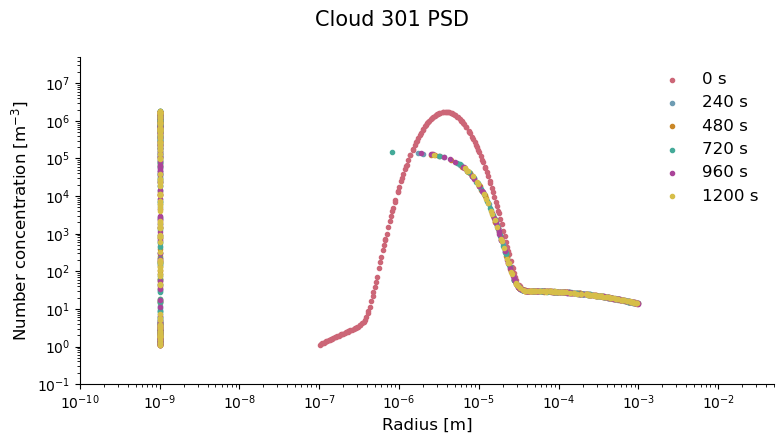

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5), sharey = True, sharex = True)


for i, t in enumerate(t2plts):
    
    # plot PSD
    ax.scatter(
        ds_top_gridbox.radius.sel(time = t),
        ds_top_gridbox.xi.sel(time = t),
        label= f"{t.values:.0f} s",
        marker = '.',
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Radius [m]")
ax.set_ylabel("Number concentration [m$^{-3}$]")

ax.set_xlim(1e-10, 5e-2)
ax.set_ylim(1e-1, 5e7)
ax.legend()

fig.suptitle(f"Cloud {cloud_id} PSD")
fig.tight_layout()
fig.savefig(fig_directory / "domain_top_psd.png")

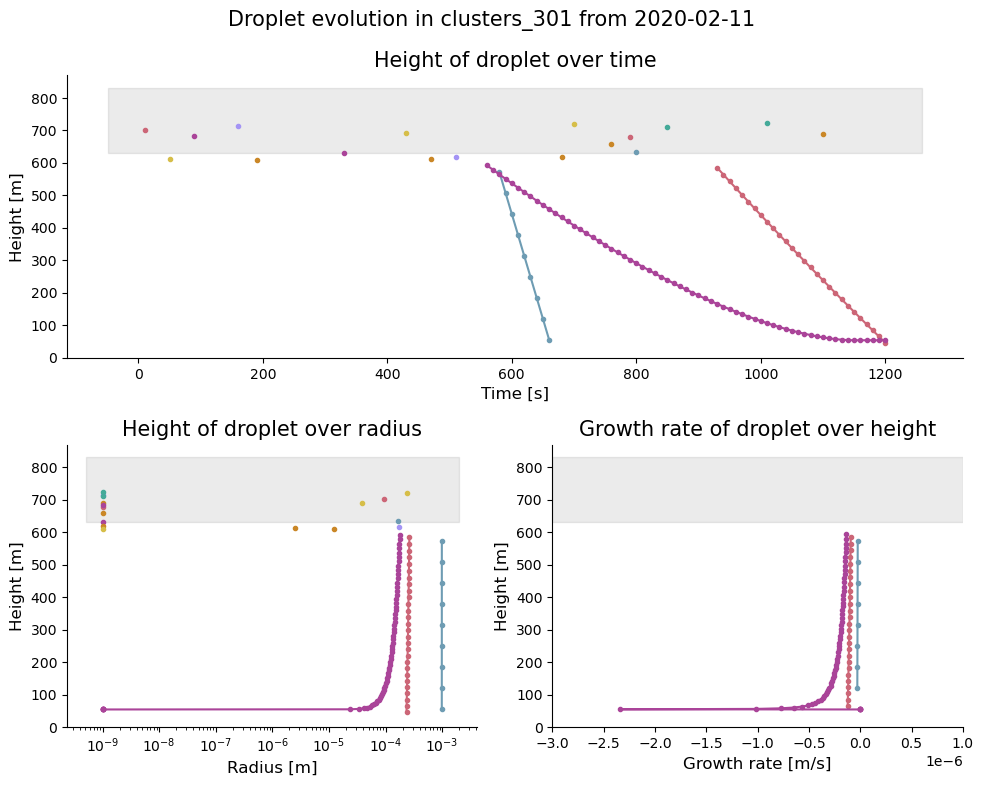

In [33]:
np.random.seed(42)
ids = np.random.choice(ds_cleo_all["sdId"], 100)

fig = plt.figure(tight_layout=True, figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))


axs[0].plot(
    ds_cleo_all["time"],
    ds_cleo_all["coord3"].sel(sdId = ids),
    '.-',
);
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Height [m]")
axs[0].set_title("Height of droplet over time")

axs[1].plot(
    ds_cleo_all["radius"].sel(sdId = ids),
    ds_cleo_all["coord3"].sel(sdId = ids),
    '.-',
);
axs[1].set_xscale("log")
axs[1].set_xlabel("Radius [m]")
axs[1].set_ylabel("Height [m]")
axs[1].set_title("Height of droplet over radius")

axs[2].plot(
    ds_cleo_all["radius"].diff("time").sel(sdId = ids) / ds_cleo_all["time"].diff("time"),
    ds_cleo_all["coord3"].isel(time = slice(0,-1)).sel(sdId = ids),
    '.-',
);
axs[2].set_xlabel("Growth rate [m/s]")
axs[2].set_ylabel("Height [m]")
axs[2].set_title("Growth rate of droplet over height")
axs[2].set_xlim(-0.3e-5, 0.1e-5)

for ax in axs:
    plot_cloud_extent(ax, cluster, alpha = 0.08)
    ax.set_ylim(0, None)

fig.suptitle(f"Droplet evolution in {identification_type}_{cloud_id} from {cluster.time.dt.date.astype(str).values[0]}")
fig.tight_layout()
fig.savefig(fig_directory / f"all_droplet_evolution_{identification_type}_{cloud_id}.png")

In [34]:
ds_cleo_all["minimum_sdgbxindex"] = ds_cleo_all["sdgbxindex"].min("time")
ds_cleo_all["minimum_sdgbxindex"].assign_attrs(
    units="m",
    long_name="Minimum grid box index of the droplet in the domain",
)

ds_cleo = ds_cleo_all.where(
    ds_cleo_all['minimum_sdgbxindex'] < ds_cleo_all['sdgbxindex'].max()-5,
    drop = True
)
display(ds_cleo)



<xarray.Dataset>
Dimensions:             (time: 121, sdId: 11101)
Coordinates:
  * sdId                (sdId) int32 260 275 277 279 ... 303404 303468 303506
  * time                (time) float64 0.0 10.0 20.0 ... 1.19e+03 1.2e+03
Data variables:
    sdgbxindex          (time, sdId) float64 nan nan nan nan ... 25.0 25.0 25.0
    xi                  (time, sdId) float64 nan nan nan ... 2.532 2.512 2.495
    radius              (time, sdId) float64 nan nan nan ... 0.0009885 0.000993
    coord3              (time, sdId) float64 nan nan nan ... 518.3 514.6 514.8
    mass                (time, sdId) float64 nan nan nan ... 4.046e-06 4.101e-06
    xi_per_gridbox      (time, sdId) float64 nan nan nan ... 2.01e+04 1.996e+04
    mass_represented    (time, sdId) float64 nan nan nan ... 1.017e-05 1.023e-05
    minimum_sdgbxindex  (sdId) float64 12.0 0.0 0.0 0.0 ... 25.0 25.0 25.0 25.0
Attributes:
    creator:      Clara Bayley
    title:        Dataset from CLEO is Xarray and NetCDF compatible Zarr Grou...
    description:  Regular shaped arrays created from the awkward arrays of th...
    creator_2:    Nils Niebaum for the regular array conversion.

Reconstruct the fitted distribution

In [35]:
cloud_base = config_yaml["thermodynamics"]["air_temperature"]["parameters"]["x_split"][0]

Calculate the mass size distribution

In [36]:
cloud_composite["mass_size_distribution"] = msd_from_psd(cloud_composite)

# get the 2D radius
cloud_composite["radius_2D"] = shape_dim_as_dataarray(
    cloud_composite["particle_size_distribution"], output_dim="radius"
)

### Create variable of $r_{init}$, $r_{max}$, $r_{final}$ and corresponding $m$ and $t$ values

In [37]:
ds_cleo["mass_represented"] = ds_cleo["mass"] * ds_cleo["xi"]
ds_cleo["mass_represented"] = ds_cleo["mass_represented"].assign_attrs(
    units="kg",
    long_name="Mass represented by the superdroplet",
)

In [38]:
# only use drolets which reach the lowest gridbox. So where the minimum of the coord3 is smaller than 20 m.
ds_cleo = ds_cleo  # .where(ds_cleo["coord3"].min("time") <= 20, drop=True)
# ds_cleo = ds_cleo.sortby(ds_cleo["radius"].isel(time = 0))
ds_cleo["minimum_coord3"] = ds_cleo["coord3"].min("time")
ds_cleo["minimum_coord3"].assign_attrs(
    units="m",
    long_name="Minimum height of the droplet in the domain",
)


ds_cleo["time_domain_leave"] = ds_cleo.isel(time=ds_cleo["coord3"].argmin("time")).time
ds_cleo["time_domain_leave"] = ds_cleo["time_domain_leave"].assign_attrs(
    units="s",
    long_name="Time when droplet leaves the domain",
)
ds_cleo["time_at_cloud_base"] = ds_cleo["time"].where(ds_cleo["coord3"] <= cloud_base).min("time")
ds_cleo["time_at_cloud_base"] = ds_cleo["time_at_cloud_base"].assign_attrs(
    units="s",
    long_name="Time when droplet reaches cloud base",
)

ds_cleo["time_at_maximum_radius"] = ds_cleo.where(
    ds_cleo["time"] == ds_cleo["radius"].argmax("time"), drop = True
).time
ds_cleo["time_at_maximum_radius"] = ds_cleo["time_at_maximum_radius"].assign_attrs(
    units="s",
    long_name="Time when droplet reaches maximum radius",
)

ds_cleo["radius_at_init"] = ds_cleo["radius"].isel(time=0)
ds_cleo["radius_at_init"] = ds_cleo["radius_at_init"].assign_attrs(
    units="m",
    long_name="Initial radius of the droplet",
)

ds_cleo["radius_at_cloud_base"] = ds_cleo["radius"].where(
    ds_cleo["time"] == ds_cleo["time_at_cloud_base"], drop = True
)
ds_cleo["radius_at_cloud_base"] = ds_cleo["radius_at_cloud_base"].assign_attrs(
    units="m",
    long_name="Radius of the droplet at cloud base",
)

ds_cleo["radius_at_domain_leave"] = ds_cleo["radius"].where(
    ds_cleo["time"] == ds_cleo["time_domain_leave"], drop = True
)
ds_cleo["radius_at_domain_leave"] = ds_cleo["radius_at_domain_leave"].assign_attrs(
    units="m",
    long_name="Radius of the droplet when it leaves the domain",
)

ds_cleo["radius_maximum"] = ds_cleo["radius"].where(ds_cleo["time"] == ds_cleo["time_at_maximum_radius"], drop = True)
ds_cleo["radius_maximum"] = ds_cleo["radius_maximum"].assign_attrs(
    units="m",
    long_name="Maximum radius of the droplet",
)

ds_cleo["mass_init"] = ds_cleo["mass"].isel(time=0)
ds_cleo["mass_init"] = ds_cleo["mass_init"].assign_attrs(
    units="kg",
    long_name="Initial mass of the droplet",
)

ds_cleo["mass_cloud_base"] = ds_cleo["mass"].where(ds_cleo["time"] == ds_cleo["time_at_cloud_base"], drop = True)
ds_cleo["mass_cloud_base"] = ds_cleo["mass_cloud_base"].assign_attrs(
    units="kg",
    long_name="Mass of the droplet at cloud base",
)

ds_cleo["mass_at_domain_leave"] = ds_cleo["mass"].where(ds_cleo["time"] == ds_cleo["time_domain_leave"], drop = True)
ds_cleo["mass_at_domain_leave"] = ds_cleo["mass_at_domain_leave"].assign_attrs(
    units="kg",
    long_name="Mass of the droplet when it leaves the domain",
)

ds_cleo["mass_maximum"] = ds_cleo["mass"].where(ds_cleo["time"] == ds_cleo["time_at_maximum_radius"], drop = True)
ds_cleo["mass_maximum"] = ds_cleo["mass_maximum"].assign_attrs(
    units="kg",
    long_name="Maximum mass of the droplet",
)
# ds_cleo["droplet_growth"] = ds_cleo["radius_at_domain_leave"] - ds_cleo["radius_at_init"]
# ds_cleo["droplet_growth_above_cloud"] = ds_cleo["radius_at_cloud_base"] - ds_cleo["radius_at_init"]
# ds_cleo["droplet_growth_below_cloud"] = ds_cleo["radius_at_domain_leave"] - ds_cleo["radius_at_cloud_base"]

## Looking at the evaporating droplets

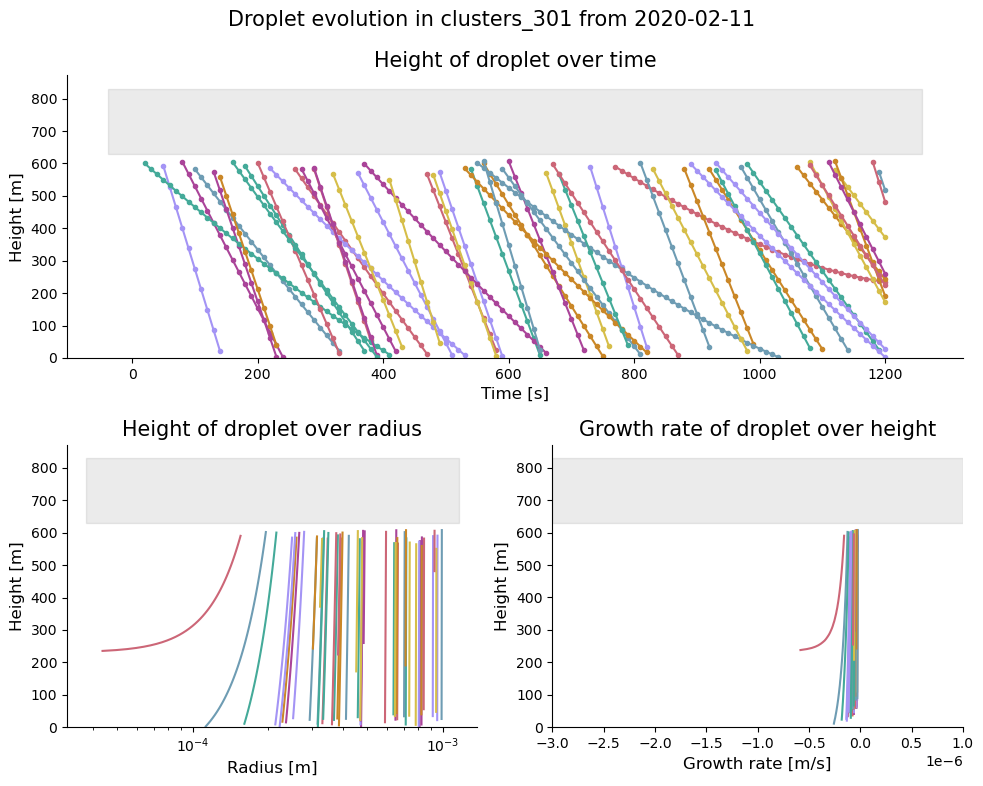

In [39]:

np.random.seed(42)
ids = np.random.choice(ds_cleo["sdId"], 50)

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))


axs[0].plot(
    ds_cleo["time"],
    ds_cleo["coord3"].sel(sdId = ids),
    '.-',
);
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Height [m]")
axs[0].set_title("Height of droplet over time")

axs[1].plot(
    ds_cleo["radius"].sel(sdId = ids),
    ds_cleo["coord3"].sel(sdId = ids)
);
axs[1].set_xscale("log")
axs[1].set_xlabel("Radius [m]")
axs[1].set_ylabel("Height [m]")
axs[1].set_title("Height of droplet over radius")

axs[2].plot(
    ds_cleo["radius"].diff("time").sel(sdId = ids) / ds_cleo["time"].diff("time"),
    ds_cleo["coord3"].isel(time = slice(0,-1)).sel(sdId = ids)
);
axs[2].set_xlabel("Growth rate [m/s]")
axs[2].set_ylabel("Height [m]")
axs[2].set_title("Growth rate of droplet over height")
axs[2].set_xlim(-0.3e-5, 0.1e-5)

for ax in axs:
    plot_cloud_extent(ax, cluster, alpha = 0.08)
    ax.set_ylim(0, None)

fig.suptitle(f"Droplet evolution in {identification_type}_{cloud_id} from {cluster.time.dt.date.astype(str).values[0]}")
fig.tight_layout()
fig.savefig(fig_directory / f"droplet_evolution_{identification_type}_{cloud_id}.png")

In [40]:
# Define the radius and altitude bins
r_bins = np.logspace(-7, -3, 100)
h_bins = np.arange(0, int(ds_cleo["coord3"].max()) + 20, 20)

# Find the bin indices for r and h
# In other words digitize the continous values of r and h into the bins
r_bin_indices = np.digitize(ds_cleo["radius"], r_bins) - 1
h_bin_indices = np.digitize(ds_cleo["coord3"], h_bins) - 1

# Initialize the arrays to store the results
m, i, j = len(ds_cleo["time"]), len(r_bins - 1), len(h_bins - 1)
psd = np.zeros((m, i, j))
msd = np.zeros((m, i, j))
evap = np.zeros((m, j))
mass = np.zeros((m, j))


mass_diff = ds_cleo["mass_represented"].diff("time")
mass = ds_cleo["mass_represented"].sel(time = slice(0, None))
# Loop over the unique bin combinations
for h_bin in range(j):
    # for r_bin in range(i):
    #     # Find the indices where r and h fall into this bin
    #     indices = (r_bin_indices == r_bin) & (h_bin_indices == h_bin)
    #     # Sum the corresponding values xi along the sd_id dimension and store the result of the
    #     # Particle size distribution
    #     res = np.where(indices, ds_cleo["xi"], np.nan)
    #     psd[:, r_bin, h_bin] = np.nansum(res, axis=1)
    #     # Sum the corresponding values the represented mass along the sd_id dimension and store the result of the
    #     # Particle size distribution
    #     res = np.where(indices, ds_cleo["mass_represented"], np.nan)
    #     msd[:, r_bin, h_bin] = np.nansum(res, axis=1)


    # Find the indices where r and h fall into this bin
    indices = (h_bin_indices[:-1,:] == h_bin)
    # Sum the corresponding values xi along the sd_id dimension and store the result of the
    # Particle size distribution
    res = np.where(indices, mass_diff, np.nan)
    evap[1:, h_bin] = np.nansum(res, axis=1)
    indices = (h_bin_indices == h_bin)
    res = np.where(indices, mass, np.nan)
    mass[:, h_bin] = np.nansum(res, axis=1)

In [41]:
ds_euler = xr.Dataset(
    data_vars=dict(
        particle_size_distribution=(
            ["time", "radius_bins", "height_bins"],
            psd,
            {"long_name": "Particle size distribution", "units": "1/m^3"},
        ),
        mass_size_distribution=(
            ["time", "radius_bins", "height_bins"],
            msd,
            {"long_name": "Mass size distribution", "units": "kg/m^3"},
        ),
        evaporation=(
            ["time", "height_bins"],	
            evap,
            {"long_name": "Evaporation rate", "units": "kg/dt"},
        ),
        mass=(
            ["time", "height_bins"],	
            evap,
            {"long_name": "mass", "units": "kg"},
        )
    ),
    coords={
        "time": ds_cleo["time"],
        "radius_bins": r_bins,
        "height_bins": h_bins,
    },
)


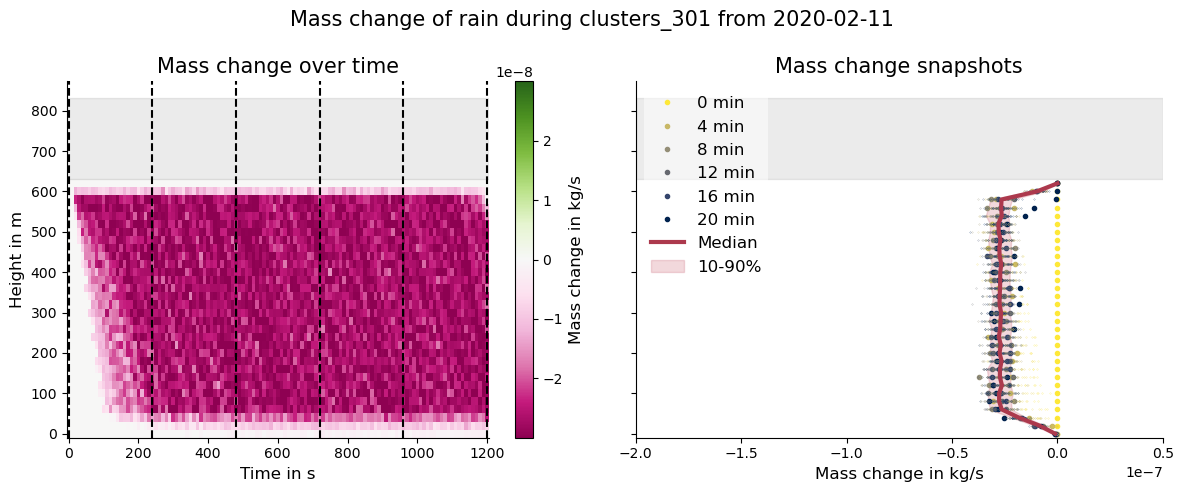

In [42]:
from matplotlib import colors
import matplotlib as mpl

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey = True)

divnorm=colors.TwoSlopeNorm(vmin=-3e-8, vcenter=0., vmax=3e-8)

pcm = axs[0].pcolormesh(
    ds_euler['time'],
    ds_euler['height_bins'],
    ds_euler['evaporation'].T/ ds_euler["time"].diff("time").mean(),
    norm=divnorm, 
    shading = 'nearest',
    cmap = "PiYG"
)
fig.colorbar(ax = axs[0], mappable = pcm, label = f'Mass change in kg/s')

axs[0].set_xlabel("Time in s")
axs[0].set_title("Mass change over time")
axs[0].set_ylabel("Height in m")
# axs[0].set_xlim(0, 20*60)

for t_value in t2plts:
    axs[0].axvline(
        t_value,
        color = 'k',
        linestyle = '--',
    )
# Plot the cummulative evaporation over time


plot_multiple_timesteps_same_ax(
    ax = axs[1],
    x = ds_euler['evaporation'] / ds_euler["time"].diff("time").mean(),
    y = ds_euler['height_bins'],
    timesteps = t2plts,
    **dict(
        linestyle = '',
        marker = '.',
    )
)

plot_multiple_timesteps_same_ax(
    ax = axs[1],
    x = ds_euler['evaporation'] / ds_euler["time"].diff("time").mean(),
    y = ds_euler['height_bins'],
    timesteps = ds_euler['time'].sel(time = slice(100, None, 1)),
    label_func = lambda x: "",
    **dict(
        linestyle = '',
        marker = '.',
        markersize = 0.3,
        alpha = 1,
    )
)

axs[1].set_xlabel("Mass change in kg/s")
axs[1].set_title("Mass change snapshots")


evaporation_50 = (ds_euler['evaporation'] / ds_euler["time"].diff("time").mean()).sel(time = slice(300, None)).median("time")
evaporation_05 = (ds_euler['evaporation'] / ds_euler["time"].diff("time").mean()).sel(time = slice(300, None)).quantile(0.10, "time")
evaporation_95 = (ds_euler['evaporation'] / ds_euler["time"].diff("time").mean()).sel(time = slice(300, None)).quantile(0.90, "time")


axs[1].plot(
    evaporation_50,
    evaporation_50['height_bins'],
    label = "Median",
    linewidth = 3,
    color = darker_colors[0],
)

axs[1].fill_betweenx(
    evaporation_05['height_bins'],
    evaporation_05,
    evaporation_95,
    color = default_colors[0],
    alpha = 0.25,
    label = "10-90%"

)


axs[1].set_xlabel("Mass change in kg/s")
axs[1].legend(loc = 'upper left')
axs[1].set_xlim(-2e-7, 0.5e-7)

for ax in axs:
    plot_cloud_extent(ax, cluster, alpha = 0.08)


fig.suptitle(f"Mass change of rain during {identification_type}_{cloud_id} from {cluster.time.dt.date.astype(str).values[0]}")
fig.tight_layout()
fig.savefig(fig_directory / f"evaporation_{identification_type}_{cloud_id}.png")

## Plot the surface precipitation


6


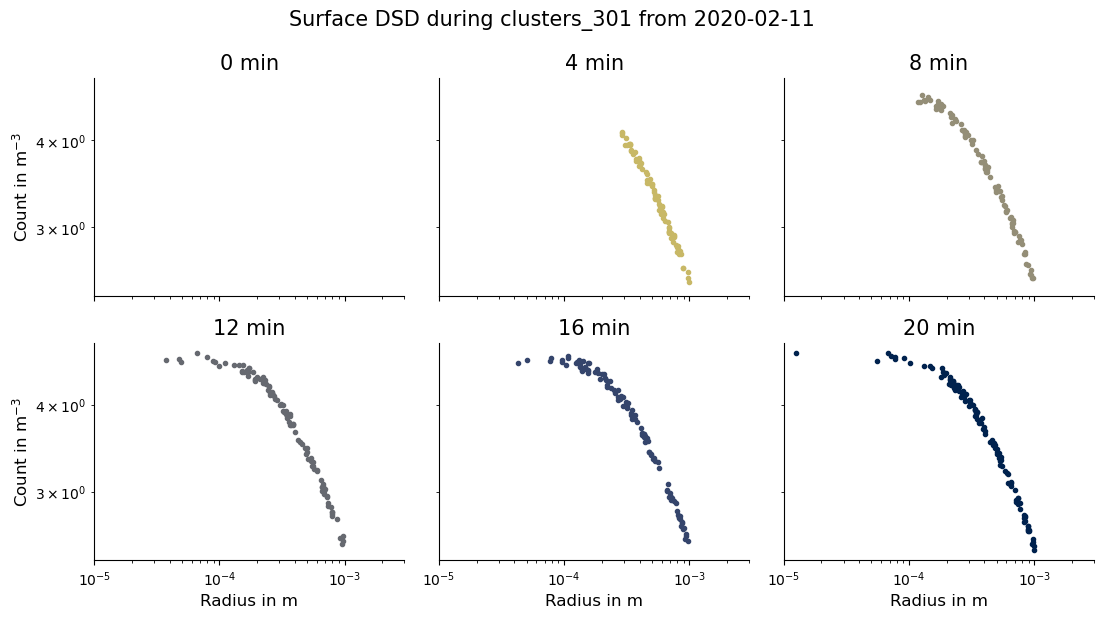

In [43]:
from typing import Tuple
from sdm_eurec4a.visulization import ncols_nrows_from_N

timesteps = t2plts
print(len(timesteps))

fig, axs = plt.subplots(figsize=(16*0.7, 9*0.7), sharex=True, sharey=True, **ncols_nrows_from_N(len(timesteps)))
ds_surface = ds_cleo.where(ds_cleo['sdgbxindex'] <= ds_cleo['sdgbxindex'].min() + 1)
plot_multiple_timesteps_diff_ax(
    axs = axs,
    x = ds_surface['radius'],
    y = ds_surface['xi'],
    timesteps = timesteps,
    time_name = "time",
    cmap = "cividis_r",
    label_func = lambda t: f"{t/60:.0f} min",
    linestyle = '',
    marker = '.',
)
for ax in axs.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1e-5, 3e-3)
for ax in axs[-1]:
    ax.set_xlabel("Radius in m")
for ax in axs[:, 0]:
    ax.set_ylabel("Count in m$^{-3}$")

fig.suptitle(f"Surface DSD during {identification_type}_{cloud_id} from {cluster.time.dt.date.astype(str).values[0]}")
fig.tight_layout()

fig.savefig(fig_directory / f"surface_dsd_{identification_type}_{cloud_id}.png")

In [44]:
ds_surface['precipitation'] = ds_surface['mass_represented'].sum("sdId") / ds_surface["time"].diff("time").mean() * 1e3 * 60
ds_surface['precipitation'] = ds_surface['precipitation'].assign_attrs(
    units="mm/h",
    long_name="Surface precipitation",
)

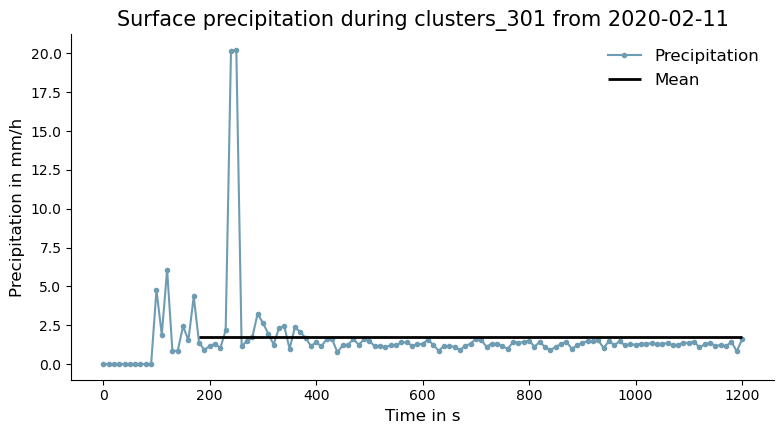

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5), sharey = True, sharex = True)

ax.plot(
    ds_surface["time"],
    ds_surface['precipitation'],
    '.-',
    label = "Precipitation",
    color = default_colors[1]
)
mean_times = ds_surface["time"].sel(time = slice(180, None))
ax.hlines(
    ds_surface['precipitation'].sel(time = mean_times).mean("time"),
    mean_times[0],
    mean_times[-1],
    color = 'k',
    label = "Mean",
    linestyle = '-',
    linewidth = 2,
)

ax.legend()
ax.set_xlabel("Time in s")
ax.set_ylabel("Precipitation in mm/h")
ax.set_title(f"Surface precipitation during {identification_type}_{cloud_id} from {cluster.time.dt.date.astype(str).values[0]}")
fig.tight_layout()
fig.savefig(fig_directory / f"surface_precipitation_{identification_type}_{cloud_id}.png")